In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sshikamaru/car-object-detection

 95% 107M/112M [00:01<00:00, 58.9MB/s] 
100% 112M/112M [00:01<00:00, 82.5MB/s]


In [7]:
!mkdir car-object-detection

In [8]:
! unzip car-object-detection.zip -d car-object-detection

Archive:  car-object-detection.zip
  inflating: car-object-detection/data/sample_submission.csv  
  inflating: car-object-detection/data/testing_images/vid_5_25100.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25120.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25140.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25160.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25180.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25200.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25220.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25240.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25260.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26320.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26400.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26420.jpg  
  inflating: car-object-detection/data

In [9]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)

Cloning into 'yolov5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 3839 (delta 18), reused 22 (delta 9), pack-reused 3801
Receiving objects: 100% (3839/3839), 7.17 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (2567/2567), done.
     |████████████████████████████████| 276kB 8.0MB/s 
CPU times: user 23.9 ms, sys: 10.8 ms, total: 34.7 ms
Wall time: 5.84 s


In [11]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [12]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_17420


(380, 676, 3)

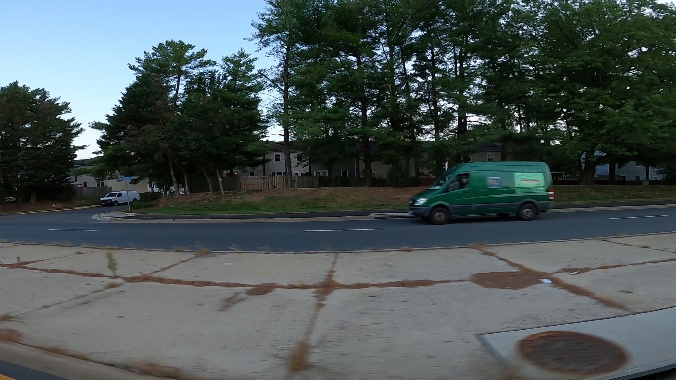

In [13]:
image = random.choice(index)
Image(filename=f'/content/car-object-detection/data/training_images/{image}.jpg',width=600)

In [14]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/car-object-detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [32]:
#!python /content/yolov5/train.py --batch 2 --epochs 1 --data /content/yolov5-config/car.yaml --cfg /content/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new

Traceback (most recent call last):
  File "/content/yolov5/train.py", line 482, in <module>
    opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
  File "/content/yolov5/utils/general.py", line 70, in check_file
    assert len(files), 'File Not Found: %s' % file  # assert file was found
AssertionError: File Not Found: /content/yolov5-config/car.yaml


In [16]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/car-object-detection/data/testing_images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=676, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/car-object-detection/data/testing_images', update=False, view_img=False, weights=['yolov5/yolov5s.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

100% 14.5M/14.5M [00:00<00:00, 21.4MB/s]

Fusing layers... 
Model Summary: 232 layers, 7459581 parameters, 0 gradients, 17.5 GFLOPS
image 1/175 /content/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 Done. (0.024s)
image 2/175 /content/car-object-detection/data/testing_images/vid_5_25120.jpg: 416x704 Done. (0.010s)
image 3/175 /content/car-object-detection/data/testing_images/vid_5_25140.jpg: 416x704 Done. (0.010s)
image 4/175 /content/car-object-detection/data/testing_images/vid_5_25160.jpg: 416x704 Done. (0.010s)
image 5/175 /content/car-object-detection/data/testing_images/vid_5_25180.jpg: 416x7

In [19]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/content/runs/detect/exp"):
    predicted_files.extend(filenames)

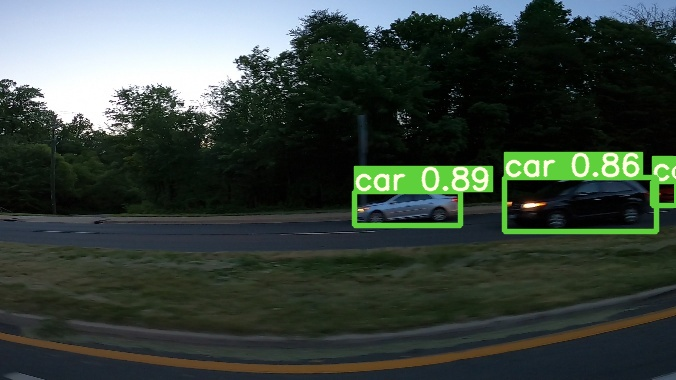

In [21]:
Image(filename=f'/content/runs/detect/exp/{random.choice(predicted_files)}')

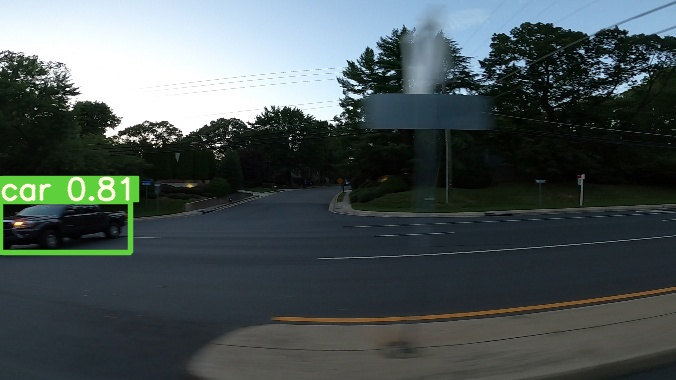

In [25]:
Image(filename=f'/content/runs/detect/exp/{random.choice(predicted_files)}')

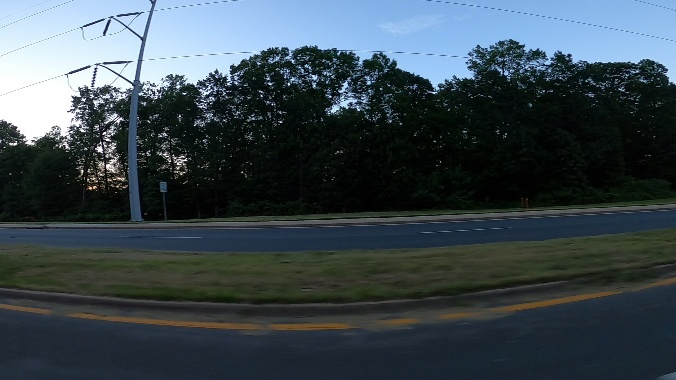

In [27]:
Image(filename=f'/content/runs/detect/exp/{random.choice(predicted_files)}')

In [28]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/ddd.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=676, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/ddd.jpg', update=False, view_img=False, weights=['yolov5/yolov5s.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Fusing layers... 
Model Summary: 232 layers, 7459581 parameters, 0 gradients, 17.5 GFLOPS
image 1/1 /content/ddd.jpg: 544x704 1 persons, 4 cars, Done. (0.014s)
Results saved to runs/detect/exp2
Done. (0.047s)


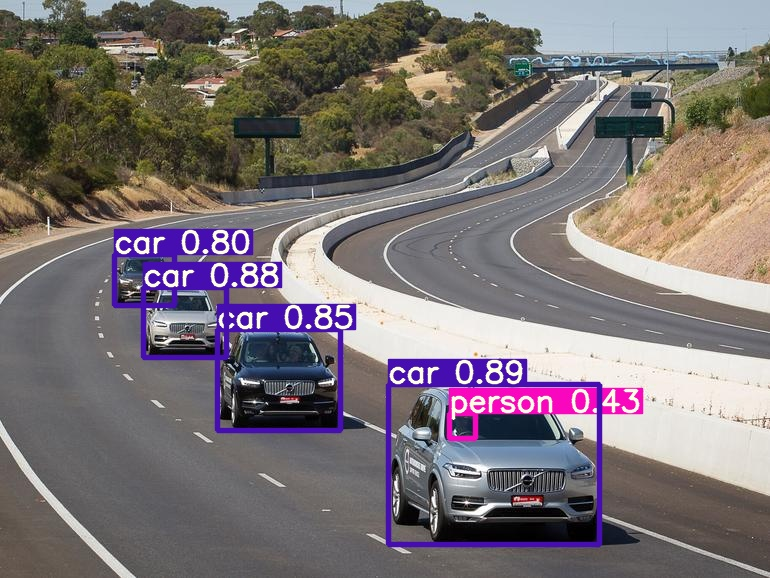

In [30]:
Image(filename=f'/content/runs/detect/exp2/ddd.jpg')